# Implementation Comparison ASF DataSketches vs datasketch

We compare implementations of the HyperLogLog algorithm from the [Apache Software Foundation DataSketches](https://github.com/apache/datasketches-cpp/tree/master/python) library and the open-source python [datasketch](https://github.com/ekzhu/datasketch).  Both libraries present python implementations or bindings for common "sketching" algorithms.
In the writing we abbreviate the two implementations as `ASF:HLL` for the ASF DataSketches 
and `datasketch:HLL` for the other implementation.

This notebook needs easily available libraries that are available on PyPi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datasketches as asf
import datasketch as ds
import mmh3

In [2]:
# Plotting parameters
method_plot_params = {
    "asf" : {"color": "C0", "marker": '.'},
    "datasketch" : {"color": "C1", "marker": "^"}
}
asf_color = method_plot_params["asf"]["color"]
ds__color = method_plot_params["datasketch"]["color"]
q90_ls = "--"

params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
      "lines.linewidth": 2.5}
plt.rcParams.update(params)

## HyperLogLog API
The two libraries implement HyperLogLog (HLL) slightly differently.  We aim to find a baseline that highlights these differences.  The following tables summarize the differences.

| Feature | ASF DataSketches |
| --- | --- |
| **Type of hash functions** | 64-bit Murmurhash only   |
| **Bucket sizes (bits)** |  $4,6$ or $8$ bits.  Bucket size does not affect accuracy, only sketch size in bits. | 
|**Estimator** | Smoothly transitions across various estimators for greatest accuracy.  Implements a higher accuracy estimator for the "single" sketch setting [cite here] |

| Feature | datasketch |
| --- | --- |
| **Type of hash functions** |  `hashlib` SHA1 by default but any other callable hash functions (e.g. 32 or 64 bit Murmurhash or xxhash) |
| **Bucket sizes (bits)** | $4$ for $32$ bit hash, $8$ for $64$ bit hash. | 
|**Estimator** | Only the "standard" HLL estimators. |



### <a name="error_vs_cardinality"></a>1. Error vs Cardinality 
We study the error behaviour as the input cardinality increases.  We provide an initial comparison to highlight the differences in the estimators.
These plots are crucial to understanding error distributions of sketches and are not presented in the `datasketch` library documentation.

To generate the synthetic data, we use "Fibonacci Hashing" as a cheap way to generate a pseudorandom sequence.  This process starts with an initial selection of a $64$-bit integer.  Then, for every new item that must be generated, we add the full $64$ bit range scaled by the integer golden ratio so that every other update _intentionally_ overflows and maps once more back into the $64$ bit range.

#### 1a. Single sketch estimation

From the project root run

```./cardinality_error_experiment.py -lgk 14 -lgt 7  -lgN 20``` 

which generates $8$ "plot points" between every power of $2$ not exceeding $N = 2^{21}$.  We fix `-lgt 7` for $128$ trials and use a sketch size of with $2^{14}$.  For every trial, an fresh sketch is initialised.

*ASF DataSketches Sketch Setup*
- `hll = asf.hll_sketch(self.sketch_lgk)`

*datasketch sketch setup*
- `h = ds.HyperLogLogPlusPlus(p=self.sketch_lgk, hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])`

This setting uses the default target type for the datasketches implementation which is $8$ bits per bucket.
Does HLL bucket size only affect the serialization?

In [3]:
asf_errors = pd.read_csv("../hll_accuracy_profile_20230504/DataSketches_hll_1516lgK_14_lgT_8trials_256.csv", index_col=0)
ds__errors = pd.read_csv("../hll_accuracy_profile_20230504/datasketch_hll_1516lgK_14_lgT_8trials_256.csv", index_col=0)

lgk = 14

Text(0.5, 0, 'Input cardinality $n$')

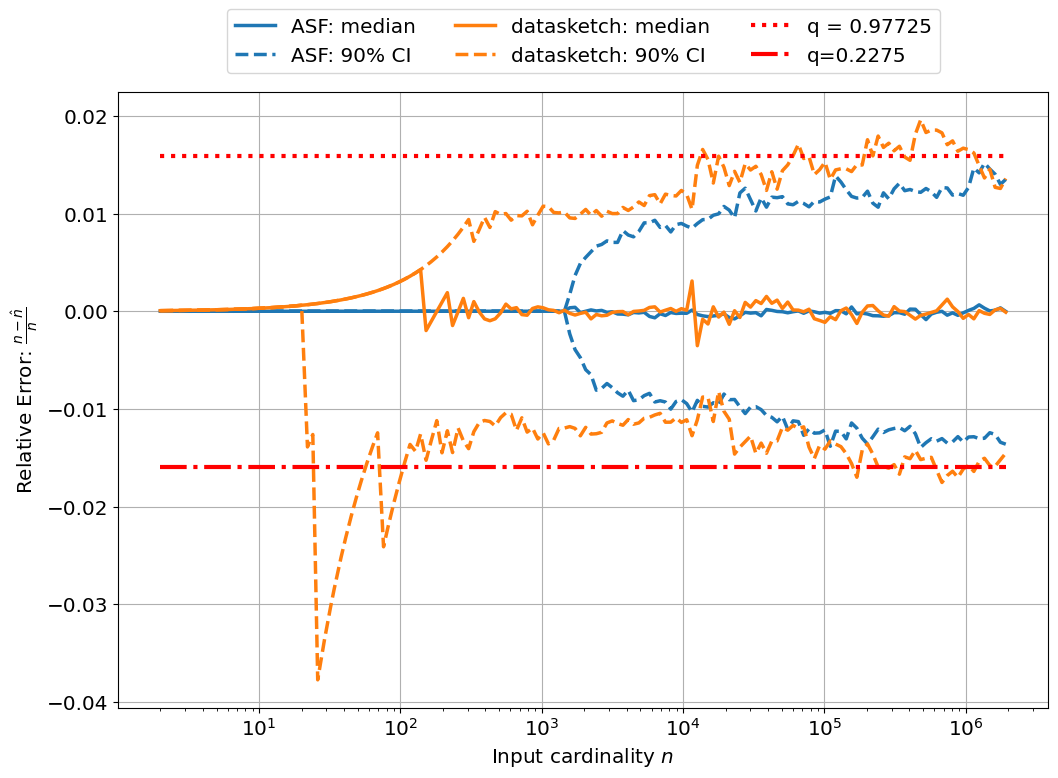

In [4]:
fig, ax = plt.subplots(figsize=(12,8))

methods = ["ASF", "datasketch"]

for i, (method, colour, df) in enumerate(zip(methods, [asf_color, ds__color], [asf_errors, ds__errors])):
    xn = df.index 
    median = df.median(axis=1)
    q95 = df.quantile(q=0.977725, axis=1)
    q05 = df.quantile(q=0.022275, axis=1) # df.mean(axis=1) - df.std(axis=1)
    ax.plot(xn, median,
           color=colour, label=method+": median")
    ax.plot(xn, q95,
           color=colour, linestyle=q90_ls)
    ax.plot(xn, q05,
           color=colour, linestyle=q90_ls, label=method+": 90% CI")

ax.plot(xn, 2.04/np.sqrt(1<<lgk)*np.ones_like(xn), 
        color="red", lw=3., linestyle=":", label="q = 0.97725")
ax.plot(xn, -2.04/np.sqrt(1<<lgk)*np.ones_like(xn), 
        color="red", lw=3., linestyle="-.",  label="q=0.2275")

ax.set_xscale('log', base=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True)
ax.grid()
ax.set_ylabel(r"Relative Error: $ \frac{n - \hat{n}}{n}$")
ax.set_xlabel(r"Input cardinality $n$")

**Experiment Summary**

The plotted red lines represent $\pm 2 \sigma$ where, for HLL, the standard error of the estimator is $\sigma = 1.04 / \sqrt{k}$. 
Hence, the area between the red lines is a confidence interval.  We have chosen the quantiles 
$q = 0.022275, 0.977725$ so that the area between the red lines is approximately a $90\%$ confidence interval.
This test uses a number of buckets $k = 2^{14}$.  Changing the number of buckets in the sketch alters the standard error so the red lines, and the behaviour of the error curves at quantile level $q$, would change appropriately.


Both implementations have a median that is centered about an error of $0$, suggesting that they are unbiased estimators.  At small cardinalities, `ASF:HLL` is vastly better than the `datasketch:HLL`.  This is because it transitions through various estimators to ensure small error.  All of the curves for `ASF:HLL` have zero error until about $n = 10^3$ because it is in sparse mode and a different estimator can be used.  Without this behaviour and resorting to the standard change of estimators as reported in [cite] can cause the wild error curves at small cardinalities.  It is important to be accurate on low cardinality inputs as many big data streams are power-law distributed, so only a few have extremely large cardinality, while many might be have small cardinality.

At large cardinalities, _for a single sketch_, `ASF:HLL` uses the HIP estimator which mildly improves on the standard large cardinality estimator.  However, when we need to merge sketches later on, this behaviour will revert to the standard HLL estimator.

### 2.  Single sketch estimation: Real data
Now let's see what happens when we want sketch some real data.  
We will download an opensource dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset#).


In [135]:
!curl -o bitcoin.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00526/data.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  110M  100  110M    0     0  5252k      0  0:00:21  0:00:21 --:--:-- 6128k258k      0  0:07:18  0:00:01  0:07:17  260k3:51  0:00:02  0:03:49  491k40k      0  0:00:22  0:00:16  0:00:06 6121k


In [137]:
!unzip bitcoin.zip

Archive:  bitcoin.zip
  inflating: BitcoinHeistData.csv    


In [5]:
bitcoin_df = pd.read_csv("BitcoinHeistData.csv", header=0)
bitcoin_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


Let's focus on the simple task of counting how many unique addresses are present in the dataset.
With native pandas functionality, we see that there are about $2.6$ million unique addresses.
We will use HLL sketches to estimate this count.

In [6]:
%%time
true_count = bitcoin_df["address"].nunique()

CPU times: user 1.15 s, sys: 89.9 ms, total: 1.24 s
Wall time: 1.26 s


In [7]:
print(f"There are {true_count} unique addresses")

There are 2631095 unique addresses


Now define equivalent sketches from both libraries.
We use $2^{14}$ buckets and $8$-bit HyperLogLog sketches for each implementation.  The `datsketch:HLL` uses the MurmurHash library so that we have equivalent sketches for comparison.

In [9]:
asf_hll = asf.hll_sketch(14, asf.HLL_8)
ds_hll = ds.HyperLogLogPlusPlus(p=14,  hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])

In [10]:
%%time
for ad in bitcoin_df["address"]:
    asf_hll.update(ad)

CPU times: user 3.93 s, sys: 32 ms, total: 3.96 s
Wall time: 4.01 s


In [11]:
%%time
for ad in bitcoin_df["address"]:
    ds_hll.update(ad)

CPU times: user 9.33 s, sys: 36.8 ms, total: 9.37 s
Wall time: 9.52 s


On this simple example we see that the datasketches implementation takes about $4$ seconds compared to about $10$ for datasketch.  Note that these times are longer than for the native Pandas call to nunique; this is not a problem because, unlike `pd.nunique(.)` the sketches are designed for large datasets not entirely held in memory.

For estimation, we have the following behaviour for the single sketches.  Since we have the true count, we can also evaluate the error.

In [12]:
# DataSketches
print(f"ASF estimate: {asf_hll.get_estimate():.4f}")
print(f"ASF error: {100*(asf_hll.get_estimate()-true_count)/true_count:.4f}  %")

ASF estimate: 2650083.4660
ASF error: 0.7217  %


In [13]:
# Datasketch
print(f"datasketch estimate: {ds_hll.count():.4f}")
print(f"datasketch error: {100*(ds_hll.count() - true_count)/true_count:.4f}  %")

datasketch estimate: 2646133.7361
datasketch error: 0.5716  %


On this example, the datasketch implementation has a lower error than the ASF method.  However, this was a single sketch so we cannot draw any strong conclusions.  Rather, we would have to study the error distribution as previously done in [Section 1](error_vs_cardinality).  

We run $25$ independent trials of each algorithm, each trial with a fresh sketch.
Since HLL is deterministic given the hash seed, with no change to the input we would obtain the same output every time.  To avoid this, we prepend the trial number to every incoming string so that the number of unique items remains the same but the streams are superficially different.

In [25]:
lgk = 14
num_trials = 25

all_asf_hll = [asf.hll_sketch(14, asf.HLL_8) for _ in range(num_trials)]
all_ds_hll = [ds.HyperLogLogPlusPlus(p=14,  hashfunc=lambda x: mmh3.hash64(x, signed=False)[0]) for _ in range(num_trials)]

asf_hll_estimates = np.zeros((num_trials,), dtype=float)
asf_hll_errors = np.zeros_like(asf_hll_estimates)
ds__hll_estimates = np.zeros_like(asf_hll_estimates)
ds__hll_errors = np.zeros_like(asf_hll_estimates)

In [26]:
%%time
for trial in range(num_trials):
    for ad in bitcoin_df["address"]:
        all_asf_hll[trial].update(str(trial) + ad)
    asf_hll_estimates[trial] = all_asf_hll[trial].get_estimate()

CPU times: user 2min 2s, sys: 1.34 s, total: 2min 3s
Wall time: 2min 9s


In [27]:
%%time
for trial in range(num_trials):
    for i, ad in enumerate(bitcoin_df["address"]):
        all_ds_hll[trial].update(str(trial) + ad)
    ds__hll_estimates[trial] = all_ds_hll[trial].count()

CPU times: user 4min 18s, sys: 806 ms, total: 4min 19s
Wall time: 4min 21s


The ASF HLL runs in about half of the time as the datasketch implementation.
However, we are also interested in the distribution of errors for each sketch implementation.
Since we have fewer trials than in Section 1, we plot a box and whisker diagram which is still useful in understanding the error distribution, despite being less informative about the full error distribution than the pitchfork plots from Section 1.  The plot can be interpreted as a cross-section of the pitchfork plot at the vertical line $n = 2631095$.

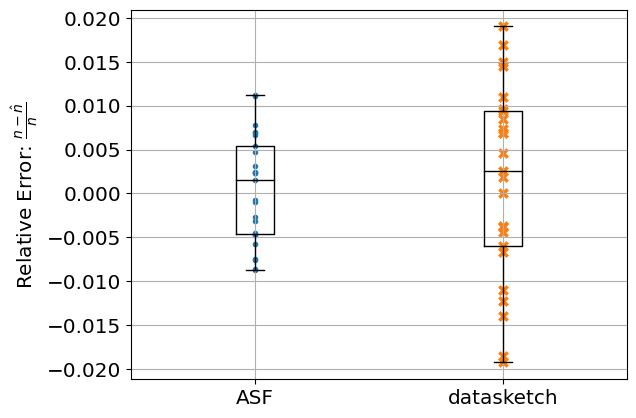

In [32]:
asf_hll_errors = (asf_hll_estimates - true_count) / true_count
datasketch_hll_errors = (ds__hll_estimates - true_count) / true_count

for arr in [asf_hll_errors, datasketch_hll_errors]:
    arr.sort()

fig, ax = plt.subplots()
error_data = {"ASF": asf_hll_errors, "datasketch": datasketch_hll_errors}

#
box_plot = ax.boxplot(list(error_data.values()), vert=True)
for median in box_plot['medians']:
    median.set_color('black')
    


ax.scatter(np.ones_like(asf_hll_errors), asf_hll_errors,  marker=".")
ax.scatter(2*np.ones_like(datasketch_hll_errors), datasketch_hll_errors, marker="x")
ax.set_xticks([1,2], list(error_data.keys()))
ax.set_ylabel(r"Relative Error: $ \frac{n - \hat{n}}{n}$")
ax.grid()

The error statistics from the experiment are as follows.

In [40]:
experiment_error_statistics = {
    "ASF": {"median" : None, "IQR" : None}, 
    "datasketch": {"median" : None, "IQR" : None}
}
key_list = list(experiment_error_statistics.keys())

for i, m in enumerate(box_plot["medians"]):
    method_median = m.get_data()[0][0]
    experiment_error_statistics[key_list[i]]["median"] = method_median

for i, line in enumerate(box_plot["boxes"]):
    liney = line.get_ydata()
    iqr = liney.max() - liney.min()
    experiment_error_statistics[key_list[i]]["IQR"] = iqr

In [41]:
experiment_error_statistics

{'ASF': {'median': 0.925, 'IQR': 0.009980189698406661},
 'datasketch': {'median': 1.925, 'IQR': 0.015456189289630978}}

In [42]:
print("{:<12}{:<12}{:<12}".format("Library", "Median", "IQR"))
print("-"*36)
for k,vd in experiment_error_statistics.items():
    print("{:<12}{:<12.4f}{:<12.4f}".format(k, vd["median"], vd["IQR"]))
    
print("\n"*2)
print("{:<12}{:<12}{:<12}".format("xChange", "Median", "IQR"))
print("-"*36)
median_factor = experiment_error_statistics["ASF"]["median"] / experiment_error_statistics["datasketch"]["median"]
iqr_factor = experiment_error_statistics["ASF"]["IQR"] / experiment_error_statistics["datasketch"]["IQR"]
print("{:<12}{:<12.4f}{:<12.4f}".format("", median_factor, iqr_factor))

Library     Median      IQR         
------------------------------------
ASF         0.9250      0.0100      
datasketch  1.9250      0.0155      



xChange     Median      IQR         
------------------------------------
            0.4805      0.6457      


These tables show that, in this example, the median reported solution using ASF DataSketches HLL is about $50\%$ closer to the true input cardinality.  Meanwhile, the interquartile range is about $65\%$ smaller when using `ASF:HLL` rather than `datasketch:HLL`. In other words, the error distribution is more tightly concentrated about the true answer.

## 3. Other key differences

There are other crucial differences in each library's API of which users should be aware.

1. The `update()` method for `ASF:HLL` accepts inputs as integers, strings, bytes, and floats. On the other hand, `datasketch:HLL` library only accepts byte and string type inputs.

In [50]:
# Datasketches HLL can accept multiple inputs
# These are treated as different items in a single sketch.
asf_hll_types = asf.hll_sketch(14, asf.HLL_8)
asf_hll_types.update(1)
asf_hll_types.update(1.0)
asf_hll_types.update(str(1))

xx = 1
xx_bytes = xx.to_bytes(64, "little")
asf_hll_types.update(xx_bytes)

asf_hll_types.get_estimate()

4.000000029802323

In [344]:
# datasketch HLL needs bytes
dhll_type = ds.HyperLogLogPlusPlus(14,  hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])
try:
    dhll_type.update(1)
except:
    print("Exception on integer input")
    
try:
    dhll_type.update(1.0)
except:
    print("Exception on float input")
    
try:
    dhll_type.update(xx_bytes)
    print("Accepts bytes input")
except:
    print("Exception on string input")
    
try:
    dhll_type.update(str(1))
    print("Accepts string input")
except:
    print("Exception on string input")
    
print(dhll_type.count()) # only two distinct items inserted into the sketch.

Exception on integer input
Exception on float input
Accepts bytes input
Accepts string input
2.000122080247517


2. The ASF HLL implementation comes with `get_upper_bound()` and `get_lower_bound()` functions.  These enable the user to understand with what confidence.  On the other hand, the `datasketch` implementation returns only the estimated count.



In [48]:
asf_hll_sketch = all_asf_hll[0]
print(f"Lower bound (1 std. dev) as % of true value: {(100*asf_hll_sketch.get_lower_bound(1) / true_count):.4f}")
print(f"ASF HyperLogLog estimate as % of true value: {(100*asf_hll_sketch.get_estimate() / true_count):.4f}")
print(f"Upper bound (1 std. dev) as % of true value: {(100*asf_hll_sketch.get_upper_bound(1) / true_count):.4f}")


Lower bound (1 std. dev) as % of true value: 99.8909
ASF HyperLogLog estimate as % of true value: 100.5406
Upper bound (1 std. dev) as % of true value: 101.1989


3. In Section 2 that the `ASF:HLL` is substantially faster.  We will study this more thoroughly in a later notebook.